In [1]:
from linear_adapter import *
from kalman import *
import torch.optim as optim
import numpy as np

X error: 0.056488927596922006 Z error:  0.056488927596922034


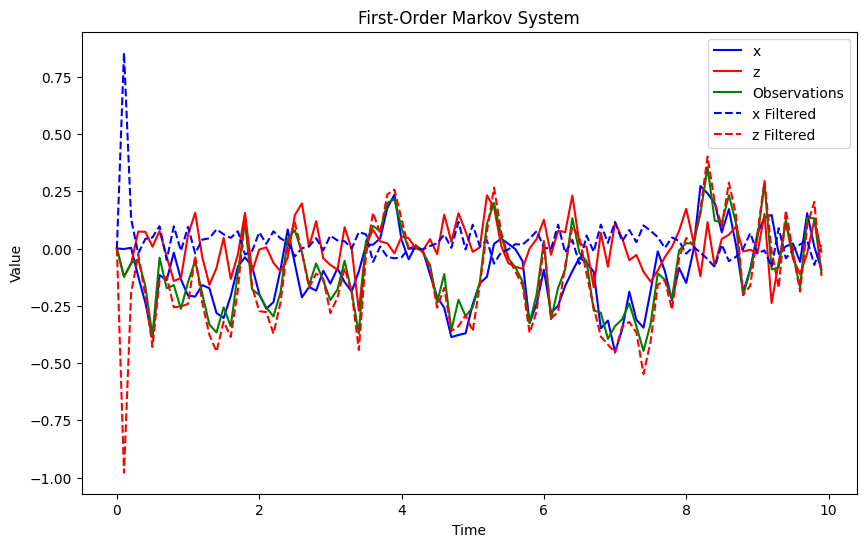

In [10]:
T = 10
dt = 0.1
t_space = np.arange(0, T, dt)

# Noise Parameters
var_x = 0.1
var_z = 0.1
var_y = 0.0


tau_x = 0.9
tau_z = 0.1


A = np.array([[(tau_x-1)/dt, 0], [0, (tau_z-1)/dt]])

initial_state = np.array([0.0, 0.0]).reshape((2, 1))
state_vec = dynamics(initial_state, t_space, A, dt, var_x, var_z)
x = state_vec[0, :]
#x = (x-x.mean())/x.std()
z = state_vec[1, :]
#z = (z-z.mean())/z.std()

H = np.array([1, 1]).reshape((1, 2))
obs = observations(H, state_vec, var_y)
covariance = np.diag([[var_x, 0], [0, var_z]])

state_hat = run_filter(initial_state.T, A, H, obs, covariance, obs_noise=var_y)

x_hat = state_hat[0, :]
z_hat = state_hat[1, :]
print('X error:', ((x-x_hat)**2).mean(), 'Z error: ', ((z-z_hat)**2).mean())
plt.figure(figsize=(10, 6))
plt.plot(t_space, x, 'b', label='x')
plt.plot(t_space, z, 'r', label='z')
plt.plot(t_space, obs, 'g', label='Observations')
plt.plot(t_space, x_hat, 'b', label = 'x Filtered ', linestyle='--')
plt.plot(t_space, z_hat, 'r', label = 'z Filtered ', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('First-Order Markov System')
plt.legend()
plt.show()


In [3]:
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        seq = data[i:i + window_size]
        target = data[i + window_size]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [4]:
window_size = 20

x_sequences, x_targets = create_sequences(x, window_size)
obs_sequences, obs_targets = create_sequences(obs, window_size)

# Train/Test Split
split_idx = int(0.7 * len(x_sequences))
x_train = torch.tensor(x_targets[:split_idx])
x_test = torch.tensor(x_targets[split_idx:])
obs_train = torch.tensor(x_sequences[:split_idx])
obs_test = torch.tensor(x_sequences[split_idx:])

#obs_train = (obs_train - obs_train.mean()) / obs_train.std()
#x_train = (x_train - x_train.mean()) / x_train.std()

# Define Adapting Network
input_dim = window_size
hidden_layers = [10]
output_dim = 1

learning_rate = 0.01
num_epochs = 100000

In [5]:
linear_model = AdaptingMLP(input_dim, hidden_layers, output_dim)
ff_model = linearNN(input_dim, hidden_layers, output_dim)

criterion = nn.MSELoss()
optimizer1 = optim.Adam(linear_model.parameters(), lr=learning_rate)
optimizer2 = optim.Adam(ff_model.parameters(), lr=learning_rate)

#Training loop
linear_model.train()
for epoch in range(num_epochs):
### Adaptive Network
    output1 = linear_model(obs_train)
    loss1 = criterion(output1.squeeze(), x_train)
    
    optimizer1.zero_grad()
    loss1.backward()
    optimizer1.step()

### Linear FF Network
    output2 = ff_model(obs_train)
    loss2 = criterion(output2.squeeze(), x_train)
    
    optimizer2.zero_grad()
    loss2.backward()
    optimizer2.step()

    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Adp. Training Loss: {loss1.item():.10f}, FF Training Loss: {loss2.item():10f}')
linear_model.eval()
linear_model.reset_hidden_states()
predicted_output = linear_model(obs_test)
test_loss = criterion(predicted_output.squeeze(), x_test)
print(f'Test Loss: {test_loss.item():.4f}')

linear_model.reset_hidden_states()

x_seq = torch.tensor(x_sequences)
linear_model_rollout = linear_model(x_seq)
ff_model_rollout = ff_model(x_seq)

Epoch [1000/100000], Adp. Training Loss: 0.0000004218, FF Training Loss:   0.000000
Epoch [2000/100000], Adp. Training Loss: 0.0000010489, FF Training Loss:   0.000001
Epoch [3000/100000], Adp. Training Loss: 0.0000071643, FF Training Loss:   0.000000
Epoch [4000/100000], Adp. Training Loss: 0.0000002065, FF Training Loss:   0.000000
Epoch [5000/100000], Adp. Training Loss: 0.0000080478, FF Training Loss:   0.000000
Epoch [6000/100000], Adp. Training Loss: 0.0001993560, FF Training Loss:   0.000000
Epoch [7000/100000], Adp. Training Loss: 0.0000047148, FF Training Loss:   0.000000
Epoch [8000/100000], Adp. Training Loss: 0.0000000085, FF Training Loss:   0.000000
Epoch [9000/100000], Adp. Training Loss: 0.0000000072, FF Training Loss:   0.000000
Epoch [10000/100000], Adp. Training Loss: 0.0000000001, FF Training Loss:   0.000000
Epoch [11000/100000], Adp. Training Loss: 0.0000001736, FF Training Loss:   0.000101
Epoch [12000/100000], Adp. Training Loss: 0.0000000001, FF Training Loss: 

KeyboardInterrupt: 

In [ ]:
linear_model.eval()
linear_model.reset_hidden_states()
predicted_output = linear_model(obs_test)
test_loss = criterion(predicted_output.squeeze(), x_test)
print(f'Test Loss: {test_loss.item():.4f}')

linear_model.reset_hidden_states()

x_seq = torch.tensor(x_sequences)
linear_model_rollout = linear_model(x_seq)
ff_model_rollout = ff_model(x_seq)

Test Loss: nan


In [ ]:
#y0 = [H @ state for state in state_vec] 

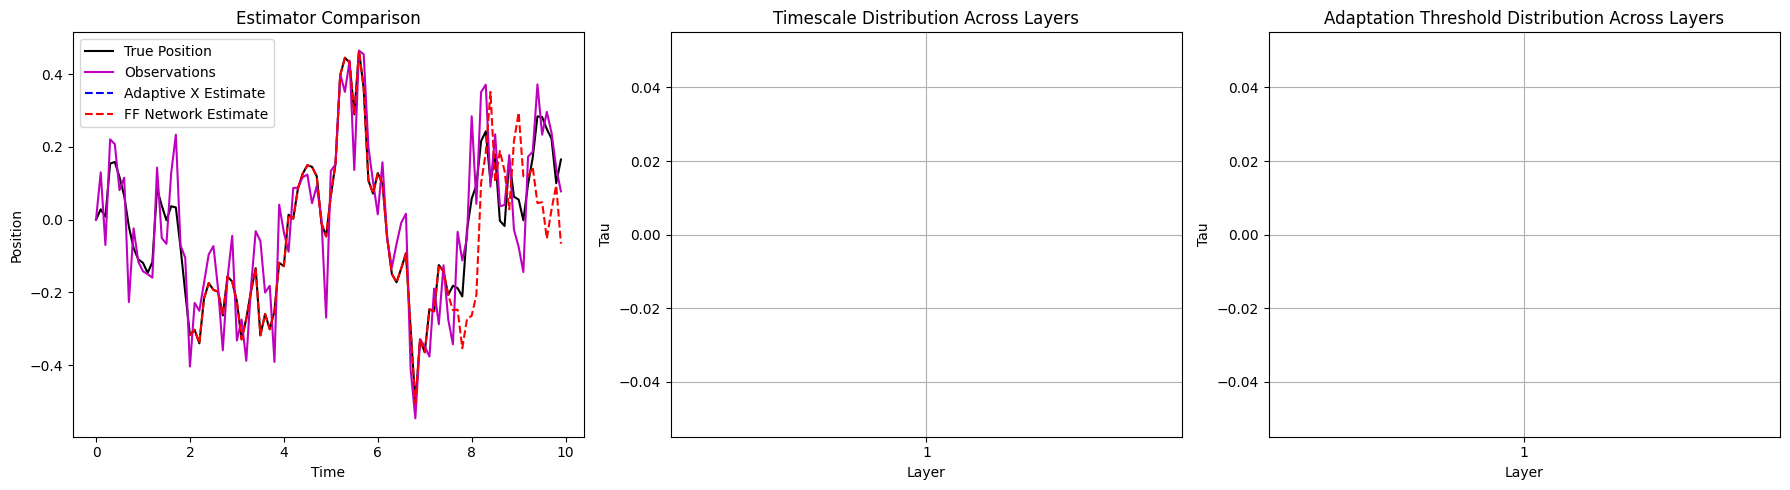

[array([0.87630592, 0.98043636,        nan, 0.99871635, 0.98734638,
       0.76705959, 0.72811398,        nan, 0.99311074, 0.47394602,
       0.99343478, 0.96      , 0.83800683, 0.90875095, 0.873026  ,
              nan, 0.8996571 ,        nan, 0.99949214, 0.71771888,
       0.97581814,        nan,        nan,        nan, 0.9162911 ,
       0.90449756, 0.93841388, 0.88811019,        nan, 0.79961127,
              nan, 0.92213547, 0.87262106, 0.88270567, 0.85982273,
       0.92210828, 0.99874978, 0.94514984, 0.87263079, 0.88168252,
       0.93661921, 0.95968427, 0.95450128, 0.91473323, 0.98299453,
              nan, 0.99999693, 0.8763587 , 0.94595718, 0.93127058,
              nan,        nan,        nan, 0.9534702 , 0.98329   ,
       0.99123235, 0.90553429, 0.88726975, 0.94935001, 0.96756885,
              nan,        nan, 0.83020458,        nan, 0.99947911,
       0.97542146, 0.98807504, 0.91790432, 0.96      ,        nan,
              nan,        nan, 0.99172627, 0.96794905,       

In [ ]:
fig = plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
# Plot results
plt.plot(t_space, x, 'k', label='True Position')
#plt.plot(t_space, z, '-r', label='Nuisance Variable')
plt.plot(t_space, obs, 'm', label='Observations')
#plt.plot(t_space, x_hat, 'g', label = 'Kalman Estimate ', linestyle='--')
plt.plot(t_space[window_size:], linear_model_rollout.detach().numpy(), 'b', label = 'Adaptive X Estimate', linestyle='--')
plt.plot(t_space[window_size:], ff_model_rollout.detach().numpy(), 'r', label = 'FF Network Estimate', linestyle='--')

#plt.ylim([-3, 3])
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Estimator Comparison')
plt.legend()


all_tau = linear_model.get_all_tau()
all_F = linear_model.get_all_F()

data_for_boxplot = [list(v) for v in all_tau]

# Plotting
#plt.figure(figsize=(10, 6))
plt.subplot(1, 3, 2)
#
plt.boxplot(data_for_boxplot, positions=np.arange(1, len(all_tau) + 1))
# Customize the plot
plt.xlabel('Layer')
plt.ylabel('Tau')
plt.title('Timescale Distribution Across Layers')
plt.xticks(np.arange(1, len(all_tau) + 1), labels=np.arange(1, len(all_tau) + 1))  # Set x-axis ticks and labels
plt.grid(True)


data_for_boxplot = [list(v) for v in all_F]
# Plotting
#plt.figure(figsize=(10, 6))

plt.subplot(1, 3, 3)
plt.boxplot(data_for_boxplot, positions=np.arange(1, len(all_F) + 1))

# Customize the plot
plt.xlabel('Layer')
plt.ylabel('Tau')
plt.title('Adaptation Threshold Distribution Across Layers')
plt.xticks(np.arange(1, len(all_F) + 1), labels=np.arange(1, len(all_F) + 1))  # Set x-axis ticks and labels
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

print(all_tau, all_F)

In [ ]:
plt.plot(x[1:]-linear_model_rollout.detach().numpy().squeeze(1), 'k')
plt.plot(x[1:]-ff_model_rollout.detach().numpy().squeeze(1))

ValueError: operands could not be broadcast together with shapes (99,) (95,) 

In [ ]:
for name, param in ff_model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

layers.0.weight tensor([[-1.0800],
        [-1.9006],
        [-0.2938],
        [ 0.6897],
        [ 0.9484],
        [ 0.7334],
        [ 0.3829],
        [-0.9696],
        [-0.1926],
        [ 0.2632],
        [-0.9585],
        [ 0.9472],
        [-0.8080],
        [ 0.9643],
        [-0.2214],
        [-0.3047],
        [-0.1335],
        [ 1.8282],
        [ 0.1116],
        [-0.0112],
        [ 0.2841],
        [ 0.6064],
        [ 0.4050],
        [ 2.0510],
        [ 0.2252],
        [-0.9180],
        [-1.7700],
        [-0.4227],
        [-0.7649],
        [ 0.0952],
        [-1.2959],
        [-0.7861],
        [ 0.9522],
        [ 0.7988],
        [-0.5778],
        [-0.3293],
        [-0.9059],
        [ 0.3996],
        [ 0.0090],
        [-0.2172],
        [ 0.4194],
        [-0.7164],
        [ 0.4410],
        [ 0.9236],
        [ 1.2535],
        [-0.6018],
        [ 0.1598],
        [ 0.9360],
        [ 1.1589],
        [ 0.4440],
        [-1.9228],
        [-1.000

In [ ]:
time = np.linspace(0, 15, 1000)  # Time from 0 to 15 with 1000 points
dt = time[1] - time[0]  # Time step
step_time = 5  # Time when the step stimulus occurs
stimulus_duration = 3  # Duration of the step stimulus
step_value = 1.0  # Value of the step stimulus
s = np.where((time >= step_time) & (time <= step_time + stimulus_duration), step_value, 0)  # Step stimulus


In [ ]:

all_tau = linear_model.get_all_tau()
all_F = linear_model.get_all_F()

print(all_tau, all_F)

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), array([0., 0.]), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])] [array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.,

0.0 0.0
0.0 0.0
0.0 0.0
0.0 0.0


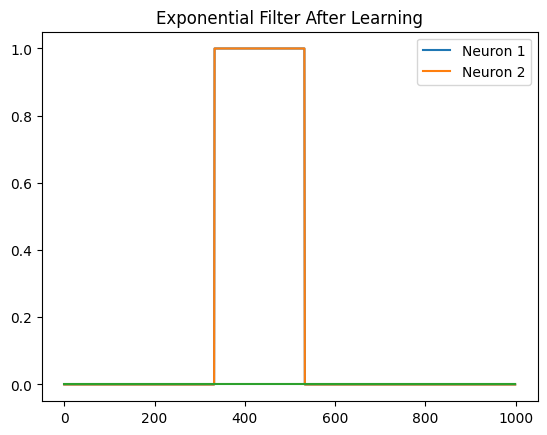

In [ ]:
arr=[]
for i in range(len(hidden_layers) + 1):
    print(np.abs(all_tau[0][i]), all_F[0][i])
    y = np.zeros_like(s)
    a = np.zeros_like(s)
    for t in range(1, len(time)):

        a[t] = a[t-1] + np.abs(all_tau[0][i]) * (-a[t-1] + np.abs(all_F[0][i])*y[t-1])
        y[t] = s[t]-a[t]
    arr.append(y)
plt.plot(arr[0], label='Neuron 1')
plt.plot(arr[1], label = 'Neuron 2')
plt.plot(a)
plt.title('Exponential Filter After Learning')
plt.legend()
plt.show()


In [ ]:
linear_model.output_layer.bias

Parameter containing:
tensor([-0.0449], requires_grad=True)